In [1]:
import matplotlib.pyplot as plt
import hyperspy.api as hs

In [30]:
import numpy as np
from matplotlib.gridspec import GridSpec

def create_cone_along_z(center_x,
                        center_y,
                        radius,
                        height_z,
                        conv_angle_factor=2):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid)*(z_grid/conv_angle_factor) + center_x
    y_grid = radius*np.sin(theta_grid)*(z_grid/conv_angle_factor) + center_y
    return x_grid,y_grid,z_grid

def plot_stem_probe(signal, 
                    ax=None,
                    ax1=None,
                    ax2=None,
                    navigator=None, 
                    conv_angle_factor=2,
                    signal_index=(1,1), 
                    signal_size=0.25, 
                    probe_below=20,
                    probe_above=9,
                    step=10):
    """ Makes a gif for some STEM hyperspy signal.
    """
    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
    import matplotlib.font_manager as fm
    fontprops = fm.FontProperties(size=18, family="serif")
    family="serif"
    
    
    if navigator is None:
        navigator = signal.sum(axis=signal.axes_manager.signal_axes).data
    nav_shape = np.shape(navigator)
    signal_shape = signal.axes_manager.signal_shape  
    
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches(5,10)
        ax = fig.add_subplot(111, projection='3d',computed_zorder=False,)
    
    # Create the Mesh Grid for the navigator

    xx, yy = np.meshgrid(np.linspace(0, 1, nav_shape[1]), np.linspace(0, 1, nav_shape[0]))
    z = 10 * np.ones(xx.shape)
    
    ax.axis("off")
    ax.contourf(xx, yy,
                navigator,
                20, zdir='z', offset=0, cmap="gray", zorder=1)
    ax.set_zlim(0,10)
    ax.set_zlim(-probe_below-6,10)
    ax.set_xlim(0.1,0.9)
    ax.set_ylim(0.1,0.9)
    
    # Create Enterance
    center = np.divide(signal_index,nav_shape)+ np.divide(0.5,nav_shape)
    Xc,Yc,Zc = create_cone_along_z(center[1],center[0],.05,probe_above)
    ax.plot_surface(Xc, Yc, Zc, alpha=0.5, color="lightskyblue", antialiased=True)

    # Create Exit
    Xc,Yc,Zc = create_cone_along_z(center[1],center[0],.05, -probe_below)
    
    ax.plot_surface(Xc, Yc, Zc,
                    alpha=0.5,
                    color="lightskyblue", zorder=-1, 
                    antialiased=True)

    # Create diffraction pattern exit wave
    xx2, yy2 = np.meshgrid(np.linspace(center[1]-signal_size, center[1]+signal_size, signal_shape[1]),
                           np.linspace(center[0]-signal_size, center[0]+signal_size, signal_shape[0]))

    ax.contourf(xx2, yy2, s.inav[signal_index[1],signal_index[0]].data,
                20, zdir='z', offset=-probe_below, cmap="hot",zorder=-2)
    ax.view_init(azim=35, elev=20)
    ax.set_box_aspect(aspect = (1,1,2))
    
    ax.text(0.5, 0.1,6,s="Rastering Probe", size=24,family=family)
    
    ax.text2D(0.015, -0.005,s="Thin Specimen",rotation=28, size=24, family=family)
    ax.text(0.5, -0.1,-30,s="Pixelated Detector", size=24, family=family)
    
    if ax1 is not None:
        partial_nav = navigator
        partial_nav[:,signal_index[0]+1:] = np.nan
        partial_nav[signal_index[1]:,signal_index[0]:]=np.nan
        ax1.imshow(partial_nav, cmap="gray", extent=signal.axes_manager.navigation_extent)
        ax1.axis("on")
        ax1.set_title("Virtual Image", size=20, family=family)
        ax1.set_ylabel("y axis (nm)", size=16, family=family)
        ax1.set_xlabel("x axis (nm)", size=16, family=family)
        ax1.set_xticks([])
        ax1.set_yticks([])
        scalebar = AnchoredSizeBar(ax1.transData,
                           50, '50 nm', 'lower left', 
                           pad=.8,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

        ax1.add_artist(scalebar)
        
    if ax2 is not None:
        ax2.imshow(s.inav[signal_index[1],
                          signal_index[0]].data,
                   cmap="hot",
                   extent=signal.axes_manager.signal_extent)
        ax2.axis("on")
        ax2.set_title("Diffraction Pattern", size=20,family=family)
        ax2.set_ylabel("k$_y$ axis ($\AA^{-1}$)", size=16,family=family)
        ax2.set_xlabel("k$_x$ axis ($\AA^{-1}$)", size=16,family=family)
        ax2.set_xticks([])
        ax2.set_yticks([])
        scalebar2 = AnchoredSizeBar(ax2.transData,
                           1, '1 $\AA^{-1}$', 'lower left', 
                           pad=0.8,
                           color='white',
                           frameon=False,
                           size_vertical=.025,
                           fontproperties=fontprops)


        ax2.add_artist(scalebar2)

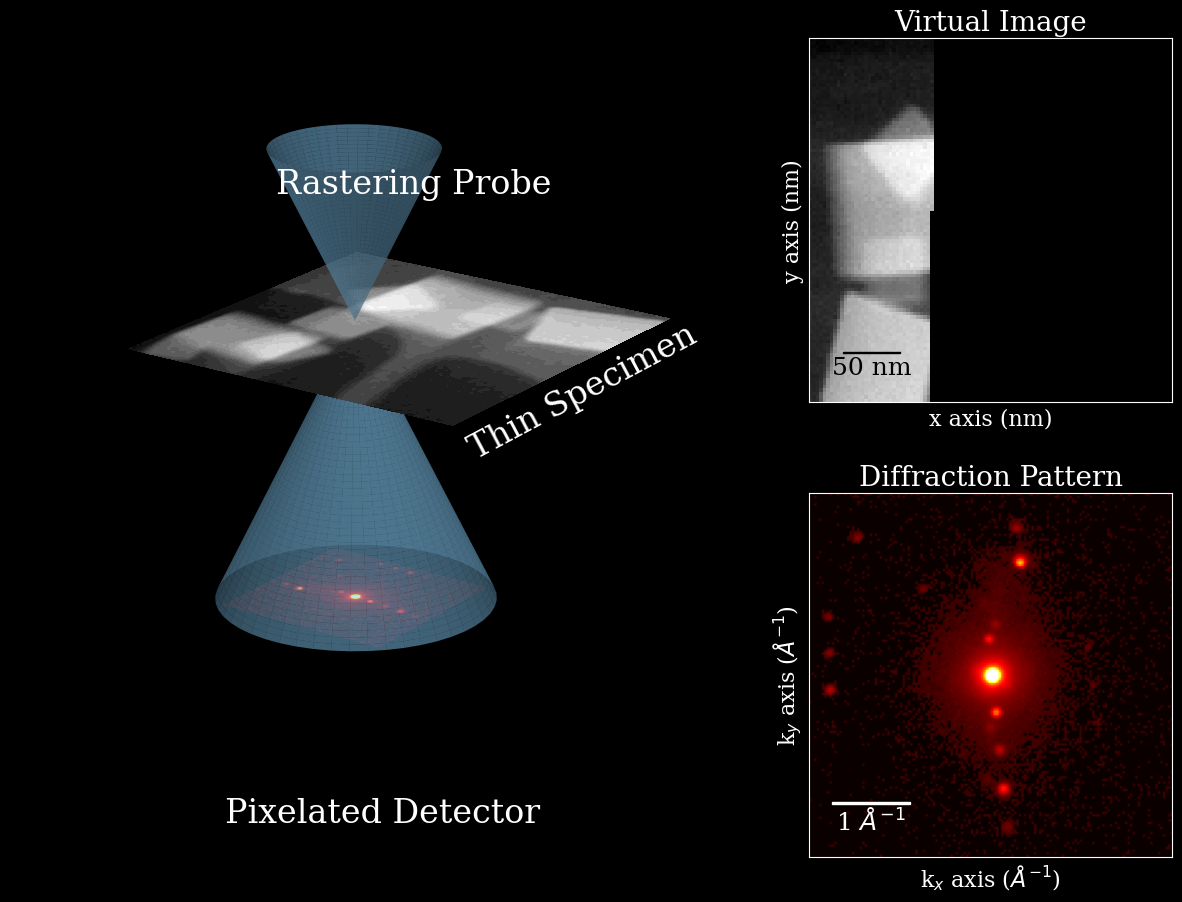

In [31]:
plt.style.use('dark_background')
fig = plt.figure()
from matplotlib.gridspec import GridSpec
fig.set_size_inches(15,15)


gs = GridSpec(2, 3,)
ax1 = fig.add_subplot(gs[:,0:2],
                      projection='3d',
                      computed_zorder=False)
ax2 = fig.add_subplot(gs[0,2],frameon=True)
ax3 = fig.add_subplot(gs[1,2],frameon=True)
ax2.axis("off")
ax3.axis("off")
fig.subplots_adjust(wspace=.1,hspace=-.35)
ax1.xaxis.pane.fill = True # Left pane
ax1.yaxis.pane.fill = True # Right pane

plot_stem_probe(s,
                signal_index=(35, 50),
                probe_below=15,
                ax=ax1,
                ax1=ax2,
                ax2=ax3, step=10)

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
plt.style.use('dark_background')

def animate_4DSTEM(signal, step=10):
    fig = plt.figure()
    fig.set_size_inches(15,15)

    gs = GridSpec(2, 3,)
    ax1 = fig.add_subplot(gs[:,0:2],
                      projection='3d',
                      computed_zorder=False,)
    ax2 = fig.add_subplot(gs[0,2])
    ax3 = fig.add_subplot(gs[1,2])
    ax2.axis("off")
    ax3.axis("off")
    fig.subplots_adjust(wspace=.1,
                        hspace=-.3,)
    indexes = list(np.ndindex(s.axes_manager.navigation_shape))
    
    indexes = indexes[::step]
    
    def animate(i):
        ax1.clear()
        ax2.clear()
        ax3.clear()
        indexes = list(np.ndindex(s.axes_manager.navigation_shape[::-1]))
        indexes = indexes[::step]
        # Get the point from the points list at index i
        plot_stem_probe(s, 
                        signal_index=indexes[i],
                        probe_below=15,
                        ax=ax1,
                        ax1=ax2, 
                        ax2=ax3, 
                        step=step)
    
    
    ani = FuncAnimation(fig, 
                        animate, 
                        frames=len(indexes),
                        interval=200, 
                        repeat=False)
    
    ani.save("4DSTEM.gif",)

In [4]:
s = hs.load("../data/mgo_nanoparticles.zspy")

In [24]:
r = hs.roi.CircleROI(cx=0, cy=0, r=2.0, r_inner=0.4)

In [25]:
nav = r(s, axes=(2,3)).nansum(axis=(2,3))

In [26]:
s.navigator=nav

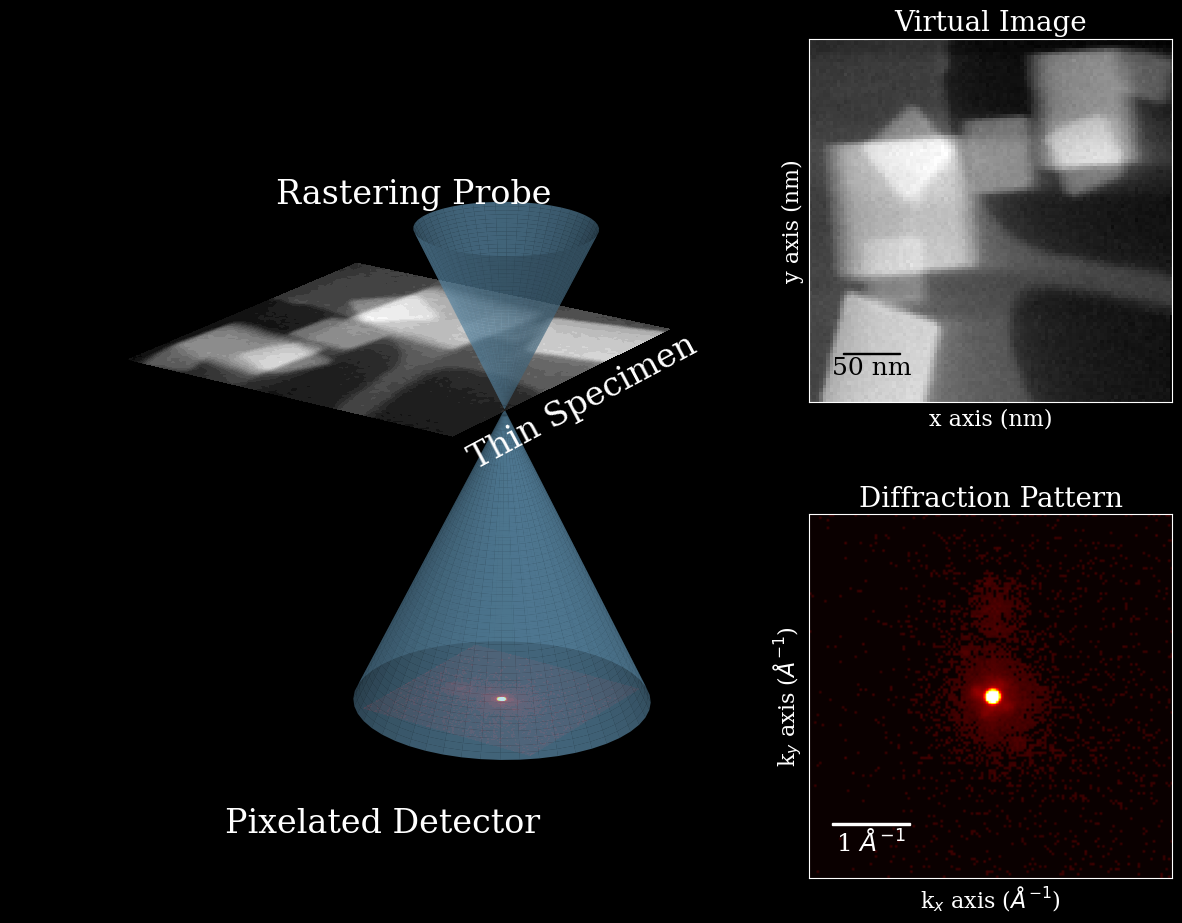

In [33]:
animate_4DSTEM(s, step=40)

In [ ]:
fig = plt.figure()
from matplotlib.gridspec import GridSpec
fig.set_size_inches(15,15)

gs = GridSpec(2, 3,)
ax1 = fig.add_subplot(gs[:,0:2],
                      projection='3d',
                      computed_zorder=False,)
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,2])
ax2.axis("off")
ax3.axis("off")
fig.subplots_adjust(wspace=.1,hspace=-.4)

plot_stem_probe(s,
                signal_index=(35, 50),
                probe_below=15,
                ax=ax1,
                ax1=ax2,
                ax2=ax3, step=10)

In [ ]:
%%timeit
plot_stem_probe(s,
                signal_index=(35, 50),
                probe_below=15,
                ax=ax1,
                ax1=ax2,
                ax2=ax3, step=10)
#ax1.axis("on")

#fig.tight_layout()

[0.71052632 0.93518519]


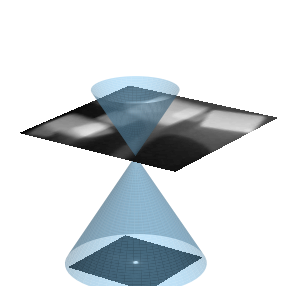

In [94]:
%matplotlib inline
plot_stem_probe(s,
                signal_index=(40,50),
                probe_below=15)


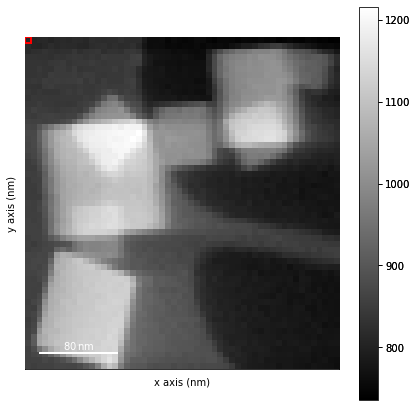

In [283]:
s.mean(axis=(2,3)).plot()

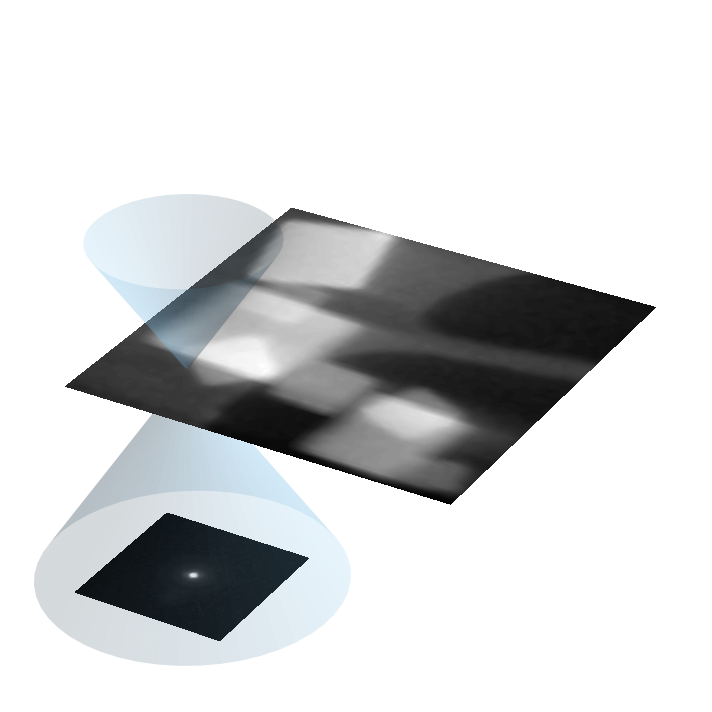

In [162]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

xx, yy = np.meshgrid(np.linspace(0, 1, 54), np.linspace(0, 1, 57))

X = xx
Y = yy
Z = 10 * np.ones(X.shape)

data = np.cos(xx) * np.cos(xx) + np.sin(yy) * np.sin(yy)
fig = plt.figure(figsize=(10,10))

#ax1 = fig.add_subplot(121)
#ax1.imshow(s.sum(axis=(2,3)).data, cmap="hot", interpolation='nearest', origin='lower', extent=[0, 1, 0, 1])

ax2 = fig.add_subplot(111, projection='3d')

ax2.axis("off")
ax2.contourf(X, Y, s.mean(axis=(3,2)).data, 100, zdir='z', offset=0, cmap="gray")
ax2.set_zlim(0,10)

ax2.set_zlim(-10,10)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

import numpy as np

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid)*(z_grid/2) + center_x
    y_grid = radius*np.sin(theta_grid)*(z_grid/2) + center_y
    return x_grid,y_grid,z_grid

Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,.05,9)
ax2.plot_surface(Xc, Yc, Zc, alpha=0.2, color="lightskyblue")

Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,.05,-15)
ax2.plot_surface(Xc, Yc, Zc, alpha=0.2, color="lightskyblue")

xx, yy = np.meshgrid(np.linspace(0.0, 0.4, 72), np.linspace(0.0, 0.4, 72))

X = xx
Y = yy
Z = 10 * np.ones(X.shape)

ax2.contourf(X, Y, s.inav[0,0].data, 100, zdir='z', offset=-15, cmap="gray")
#ax2.view_init(10, 0)
plt.show()